In [42]:
%pip install yfinance

In [43]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

#pd.set_option('display.max_rows', 500)

In [44]:
nextDays = 100
def createDataFrame(stock, start, end):
    df = stock.history(start=start, end=end)

    df["Change"] = df["Close"].pct_change() # 전날 대비 변화율

    # add next 2 days' average
    #df["Next2"] = df["Close"].rolling(window=2).mean().shift(-2)

    # add next 5 days' average
    df["Next"] = df["Close"].rolling(window=nextDays).mean().shift(-nextDays)

    # add 10 days later
    df["Next"] = (df["Close"].shift(-nextDays+1) + df["Close"].shift(-nextDays) + df["Close"].shift(-nextDays-1)) / 3




    # df.index = pd.to_datetime(df.index).strftime("%Y-%m-%d") # 날짜 형식 간단하게 만들기

    # 지표 데이터
    # df2 = pd.read_csv("/Users/ryujonghyeok/Jonghyeok/Sejong/SAI/자료모음집.csv")
    # df = pd.merge(df, df2, on="Date") """

    # df.set_index("Date", inplace=True)

    return df

In [45]:
# Define the stock
stock = yf.Ticker("SPY")

# Create a dataframe from 'start' to 'end'
start = "2009-01-01"
end = "2020-12-31"

df = createDataFrame(stock, start, end)
df = df[["Close", "Change", "Next"]]
df

,Close,Change,Next
Date,,,
2009-01-02 00:00:00-05:00,69.635735,NaN,68.685577
2009-01-05 00:00:00-05:00,69.553329,-0.001183,69.968155
2009-01-06 00:00:00-05:00,70.017754,0.006677,70.956492
2009-01-07 00:00:00-05:00,67.920273,-0.029956,71.238162
2009-01-08 00:00:00-05:00,68.197456,0.004081,71.177818
...,...,...,...
2020-12-23 00:00:00-05:00,350.511108,0.000899,NaN
2020-12-24 00:00:00-05:00,351.874695,0.003890,NaN
2020-12-28 00:00:00-05:00,354.897583,0.008591,NaN


In [46]:
# FEDFUNDS: Federal Funds Effective Rate
# DFEDTARU: Federal Funds Target Range - Upper Limit
# CPIAUCSL: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
# DGS10: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis


# access CPI.csv file in 'data' folder
cpiaucsl = pd.read_csv('https://github.com/ryujonghyeok-student/TraderJohns/blob/main/data/CPIAUCSL.csv?raw=true')
dfedtaru = pd.read_csv('https://github.com/ryujonghyeok-student/TraderJohns/blob/main/data/DFEDTARU.csv?raw=true')
dgs10 = pd.read_csv('https://github.com/ryujonghyeok-student/TraderJohns/blob/main/data/DGS10.csv?raw=true')
fedfunds = pd.read_csv('https://github.com/ryujonghyeok-student/TraderJohns/blob/main/data/FEDFUNDS.csv?raw=true')
unrate = pd.read_csv('https://github.com/ryujonghyeok-student/TraderJohns/blob/main/data/UNRATE.csv?raw=true')


# convert 'DATE' column to datetime
cpiaucsl['DATE'] = pd.to_datetime(cpiaucsl['DATE'])
dfedtaru['DATE'] = pd.to_datetime(dfedtaru['DATE'])
dgs10['DATE'] = pd.to_datetime(dgs10['DATE'])
fedfunds['DATE'] = pd.to_datetime(fedfunds['DATE'])
unrate['DATE'] = pd.to_datetime(unrate['DATE'])

# set start and end date with dataframe data type
start = pd.to_datetime(start)
end = pd.to_datetime(end)

# combine fed, cpi, treasury using merge from start to end
data = pd.merge(fedfunds, cpiaucsl, on='DATE', how='outer')
data = pd.merge(data, dfedtaru, on='DATE', how='outer')
data = pd.merge(data, dgs10, on='DATE', how='outer')
data = pd.merge(data, unrate, on='DATE', how='outer')
data = data[(data['DATE'] >= start) & (data['DATE'] <= end)]
data = data.replace(".", np.NaN)
data = data.ffill()

data.index = data['DATE']
data = data.drop(columns=['DATE'])

data

,FEDFUNDS,CPIAUCSL,DFEDTARU,DGS10,UNRATE
DATE,,,,,
2009-01-01,0.15,211.933,0.25,NaN,7.8
2009-02-01,0.22,212.705,0.25,NaN,8.3
2009-03-01,0.18,212.495,0.25,NaN,8.7
2009-04-01,0.15,212.709,0.25,2.68,9.0
2009-05-01,0.18,213.022,0.25,3.21,9.4
...,...,...,...,...,...
2020-12-27,0.09,262.005,0.25,0.94,6.7
2020-12-28,0.09,262.005,0.25,0.94,6.7
2020-12-29,0.09,262.005,0.25,0.94,6.7


In [47]:
# Convert 'df' to tz-aware dataframe
df = df.tz_localize(None)

# Combine 'df' and 'data' dataframe respect to 'DATE' as index
df = pd.merge(df, data, left_index=True, right_index=True, how='inner')

df

,Close,Change,Next,FEDFUNDS,CPIAUCSL,DFEDTARU,DGS10,UNRATE
2009-01-02,69.635735,NaN,68.685577,0.09,262.005,0.25,2.46,6.7
2009-01-05,69.553329,-0.001183,69.968155,0.09,262.005,0.25,2.49,6.7
2009-01-06,70.017754,0.006677,70.956492,0.09,262.005,0.25,2.51,6.7
2009-01-07,67.920273,-0.029956,71.238162,0.09,262.005,0.25,2.52,6.7
2009-01-08,68.197456,0.004081,71.177818,0.09,262.005,0.25,2.47,6.7
...,...,...,...,...,...,...,...,...
2020-12-23,350.511108,0.000899,NaN,0.09,262.005,0.25,0.96,6.7
2020-12-24,351.874695,0.003890,NaN,0.09,262.005,0.25,0.94,6.7
2020-12-28,354.897583,0.008591,NaN,0.09,262.005,0.25,0.94,6.7
2020-12-29,354.220520,-0.001908,NaN,0.09,262.005,0.25,0.94,6.7


In [48]:
# import the scikit learn linear regression model
from sklearn.linear_model import LinearRegression

# create a linear regression model between 'Close' and 'CPIAUCSL', 'DFEDTARU', 'DGS10', 'FEDFUNDS', 'UNRATE
model = LinearRegression()

# x = df[['CPIAUCSL', 'DFEDTARU', 'DGS10', 'FEDFUNDS', 'UNRATE']]
x = df.iloc[:-nextDays-1][['CPIAUCSL', 'DFEDTARU', 'DGS10', 'FEDFUNDS', 'UNRATE']]

# y = df['Close']
y = df.iloc[:-nextDays-1]['Next']


model.fit(x, y) # train the model

# print the model coefficients
print(model.coef_)
print(model.intercept_)
print(model.score(x, y))

""" # add predicted 'Close' values to the dataframe
df['Predicted Close'] = model.predict(x)

# plot the 'Close' and 'Predicted Close' values
plt.plot(df.index, y, label='Close')
plt.plot(df.index, model.predict(x), label='Predicted Close')
plt.legend()
plt.show() """

[  0.33490837  70.17042087 -50.9525022    5.10155291   1.26505086]
153.62430027885063
0.7494332397969499


" # add predicted 'Close' values to the dataframe\ndf['Predicted Close'] = model.predict(x)\n\n# plot the 'Close' and 'Predicted Close' values\nplt.plot(df.index, y, label='Close')\nplt.plot(df.index, model.predict(x), label='Predicted Close')\nplt.legend()\nplt.show() "

In [49]:
df

,Close,Change,Next,FEDFUNDS,CPIAUCSL,DFEDTARU,DGS10,UNRATE
2009-01-02,69.635735,NaN,68.685577,0.09,262.005,0.25,2.46,6.7
2009-01-05,69.553329,-0.001183,69.968155,0.09,262.005,0.25,2.49,6.7
2009-01-06,70.017754,0.006677,70.956492,0.09,262.005,0.25,2.51,6.7
2009-01-07,67.920273,-0.029956,71.238162,0.09,262.005,0.25,2.52,6.7
2009-01-08,68.197456,0.004081,71.177818,0.09,262.005,0.25,2.47,6.7
...,...,...,...,...,...,...,...,...
2020-12-23,350.511108,0.000899,NaN,0.09,262.005,0.25,0.96,6.7
2020-12-24,351.874695,0.003890,NaN,0.09,262.005,0.25,0.94,6.7
2020-12-28,354.897583,0.008591,NaN,0.09,262.005,0.25,0.94,6.7
2020-12-29,354.220520,-0.001908,NaN,0.09,262.005,0.25,0.94,6.7


In [50]:
def buy(현금보유량, 주식보유량, 현재주가):
    if 주식보유량 == 0:
        주식보유량 = 현금보유량 // 현재주가
        현금보유량 -= 주식보유량 * 현재주가
        # print(f"Bought at {현재주가} with {주식보유량} stocks")
    return 현금보유량, 주식보유량


def sell(현금보유량, 주식보유량, 현재주가):
    if 주식보유량 > 0:
        현금보유량 += 주식보유량 * 현재주가
        주식보유량 = 0
        # print(f"Sold at {현재주가} with {주식보유량} stocks")
    return 현금보유량, 주식보유량

def total_asset(현금보유량, 주식보유량, 현재주가):
    return 현금보유량 + 주식보유량 * 현재주가

In [51]:
buyAndHold_plt = []
# 시작시점에 매수 후 종료시점에 매도
def strategy_buyAndHold(df):
    global buyAndHold_plt

    현금보유량 = 1000000
    주식보유량 = 0

    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)

    buyAndHold_plt = []
    for i in range(1, len(df)-1):
        buyAndHold_plt.append(total_asset(현금보유량, 주식보유량, df.iloc[i].Close))

    현금보유량 += 주식보유량 * df.iloc[-1].Close

    print(f"Hold - 현금보유량: {현금보유량:.2f}, profit: {(현금보유량-1000000)/1000000*100:.2f}%")


In [52]:
difference_plt = []
# 최고점 대비 일정 비율 하락하면 매도, 최저점 대비 일정 비율 상승하면 매수
def strategy_difference(df):
    global difference_plt
    현금보유량 = 1000000
    주식보유량 = 0
    dif1 = 0.36 # 일정 비율 하락하는 정도 🤑
    dif2 = 0.02 # 일정 비율 상승하는 정도 🤑

    minimum = float('inf')
    maximum = float('-inf')

    for i in range(2, len(df)):
        price = df.iloc[i].Close
        if price > maximum:
            maximum = price
        elif price < minimum:
            minimum = price
        if 주식보유량 > 0 and price < maximum * (1-dif1):
            print("DIF - Bought")
            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, price)
            maximum = float('-inf')
        elif 주식보유량 == 0 and price > minimum * (1+dif2):
            #print(f"Bought at {price(hist, i)}")
            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, price)
            minimum = float('inf')

        difference_plt.append(total_asset(현금보유량, 주식보유량, price))

    현금보유량 += 주식보유량 * df.iloc[-1].Close
    주식보유량 = 0

    print(f"Difference - 현금보유량: {현금보유량:.2f}, profit: {(현금보유량-1000000)/1000000*100:.2f}%")

In [53]:
""" import requests
import datetime
import pandas as pd
from bs4 import BeautifulSoup

requests.packages.urllib3.disable_warnings()

def scraper(url):
    resp = requests.get(url, verify=False)
    page = resp.text
    soup = BeautifulSoup(page, "html.parser")

    body_copy = str(soup.find_all("p", {"class": "body-copy"}))
    body_copy = body_copy.replace('<p class="body-copy">', '')
    body_copy = body_copy.replace('</p>', '')

    return body_copy


for i in range(1, len(df)):
    a = df.iloc[i].name
    a = a.strftime("%b-%d-%Y")
    a = str(a).lower()
    url = f"https://www.investrade.com/market-review-{a}/"
    content = scraper(url)
    df.loc[df.index[i], "Title"] = content

df.tail()

 """

' import requests\nimport datetime\nimport pandas as pd\nfrom bs4 import BeautifulSoup\n\nrequests.packages.urllib3.disable_warnings()\n\ndef scraper(url):\n    resp = requests.get(url, verify=False)\n    page = resp.text\n    soup = BeautifulSoup(page, "html.parser")\n\n    body_copy = str(soup.find_all("p", {"class": "body-copy"}))\n    body_copy = body_copy.replace(\'<p class="body-copy">\', \'\')\n    body_copy = body_copy.replace(\'</p>\', \'\')\n\n    return body_copy\n\n\nfor i in range(1, len(df)):\n    a = df.iloc[i].name\n    a = a.strftime("%b-%d-%Y")\n    a = str(a).lower()\n    url = f"https://www.investrade.com/market-review-{a}/"\n    content = scraper(url)\n    df.loc[df.index[i], "Title"] = content\n\ndf.tail()\n\n '

In [54]:
def score_calculate_og(i):
    # 4.76130047  -2.86062042 -31.53250228  -8.93819761  -6.0887131
    # x = df[['CPIAUCSL', 'DFEDTARU', 'DGS10', 'FEDFUNDS', 'UNRATE']]

    d_cpiaucsl = float(df.iloc[i]["CPIAUCSL"])
    d_dfedtaru = float(df.iloc[i]["DFEDTARU"])
    d_dgs10 = float(df.iloc[i]["DGS10"])
    d_fedfunds = float(df.iloc[i]["FEDFUNDS"])
    d_unrate = float(df.iloc[i]["UNRATE"])

    # [  3.31071085   5.16950057  -2.57965745 -19.2770091  -34.5469385 ]
    # -414.4216677959783

    score = 4.76130047 * d_cpiaucsl - 2.86062042 * d_dfedtaru - 31.53250228 * d_dgs10 - 8.93819761 * d_fedfunds - 6.0887131 * d_unrate -838.334901756302
    score = 3.31071085 * d_cpiaucsl + 5.16950057 * d_dfedtaru - 2.57965745 * d_dgs10 - 19.2770091 * d_fedfunds - 34.5469385 * d_unrate -414.4216677959783

    # [  5.87635666 -20.95913652   8.94047031  19.06006088   2.26623342]
    # -1252.8649401375355
    score = 5.87635666 * d_cpiaucsl - 20.95913652 * d_dfedtaru + 8.94047031 * d_dgs10 + 19.06006088 * d_fedfunds + 2.26623342 * d_unrate -1252.8649401375355

    return score

def score_calculate(i):
    # [  4.33353229  -2.0621398   -5.18311157 -15.21641093 -46.91571719]
    # -609.9466426959245


    d_cpiaucsl = float(df.iloc[i]["CPIAUCSL"])
    d_dfedtaru = float(df.iloc[i]["DFEDTARU"])
    d_dgs10 = float(df.iloc[i]["DGS10"])
    d_fedfunds = float(df.iloc[i]["FEDFUNDS"])
    d_unrate = float(df.iloc[i]["UNRATE"])

    # [  5.69925028 -48.076492     1.56366513  53.42014896   4.19152599]
    # -1199.3135901021014

    score = 4.33353229 * d_cpiaucsl - 2.0621398 * d_dfedtaru - 5.18311157 * d_dgs10 - 15.21641093 * d_fedfunds - 46.91571719 * d_unrate -609.9466426959245
    score = 5.87635666 * d_cpiaucsl - 20.95913652 * d_dfedtaru + 8.94047031 * d_dgs10 + 19.06006088 * d_fedfunds + 2.26623342 * d_unrate -1252.8649401375355
    score = 5.55300228 * d_cpiaucsl - 32.33691206 * d_dfedtaru + 4.82001601 * d_dgs10 + 36.57436438 * d_fedfunds + 2.97079608 * d_unrate -1170.3482155841334
    score = 5.44129951 * d_cpiaucsl - 21.80079886 * d_dfedtaru + 8.01323566 * d_dgs10 + 24.88876588 * d_fedfunds + 1.66806938 * d_unrate -1147.2719098050673 # Result of SPY 20090101-20201231 and to the avg of 9, 10, 11th day
    score = 5.69925028 * d_cpiaucsl - 48.076492 * d_dfedtaru + 1.56366513 * d_dgs10 + 53.42014896 * d_fedfunds + 4.19152599 * d_unrate -1199.3135901021014 # Result of SPY20090101-20201231 and to the avg of 99, 100, 101st day





    return score


score_plt = []
# 복합적인 요소를 분석하여 일정 조건에 따라 매수 및 매도 반복
def strategy_score(df):
    global score_plt

    현금보유량 = 1000000
    주식보유량 = 0

    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)

    for i in range(len(df)):

        # Calculate the initial score
        score = score_calculate(i)

        현재주가 = df.iloc[i].Close



        # 점수가 일정 기준보다 클 때 매수하기
        # If x in "score * x" is greater than 1, then it is much easier to buy the stock
        if  현재주가 < score * 1.2:
            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, 현재주가)

        # 점수가 일정 기준보다 작을 때 매도하기
        # if x  in "score * x" is greater than 1, then it is much harder to sell the stock
        elif 현재주가 > score * 1.05:
            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, 현재주가)

        score_plt.append(total_asset(현금보유량, 주식보유량, 현재주가))

    현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, df.iloc[-1].Close)


    print(f"Score 계산 - 현금보유량: {현금보유량:.2f} profit: {(현금보유량-1000000)/1000000*100:.2f}%")


In [55]:
score2_plt = []
def strategy_score2(df):
    global score2_plt
    현금보유량 = 1000000
    주식보유량 = 0
    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)


    # Adaption of difference-strategy
    dif1 = 0.2 # 일정 비율 하락하는 정도
    dif2 = 0.02 # 일정 비율 상승하는 정도

    minimum = float('inf')
    maximum = float('-inf')

    for i in range(len(df)):

        # Calculate the initial score
        score = score_calculate(i)

        현재주가 = df.iloc[i].Close


        price = df.iloc[i].Close
        if price > maximum:
            maximum = price
        elif price < minimum:
            minimum = price
        if 주식보유량 > 0 and price < maximum * (1-dif1):
            print("BOUGHT ALERT")
            score * 1.1
            maximum = float('-inf')
        elif 주식보유량 == 0 and price > minimum * (1+dif2):
            print("SOLD ALERT")
            score *= 0.9
            minimum = float('inf')

        # 점수가 일정 기준보다 클 때 매수하기
        # If x in "score * x" is greater than 1, then it is much easier to buy the stock
        if  현재주가 < score * 1.2:
            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, 현재주가)

        # 점수가 일정 기준보다 작을 때 매도하기
        # if x  in "score * x" is greater than 1, then it is much harder to sell the stock
        elif 현재주가 > score * 1.05:
            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, 현재주가)

        score2_plt.append(total_asset(현금보유량, 주식보유량, 현재주가))

    현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, df.iloc[-1].Close)


    print(f"Score2 계산 - 현금보유량: {현금보유량:.2f} profit: {(현금보유량-1000000)/1000000*100:.2f}%")


Hold - 현금보유량: 5093895.09, profit: 409.39%
Difference - 현금보유량: 5633805.54, profit: 463.38%
Score 계산 - 현금보유량: 4739244.76 profit: 373.92%
BOUGHT ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
SOLD ALERT
BOUGHT ALERT
Score2 계산 - 현금보유량: 4739244.76 profit: 373.92%


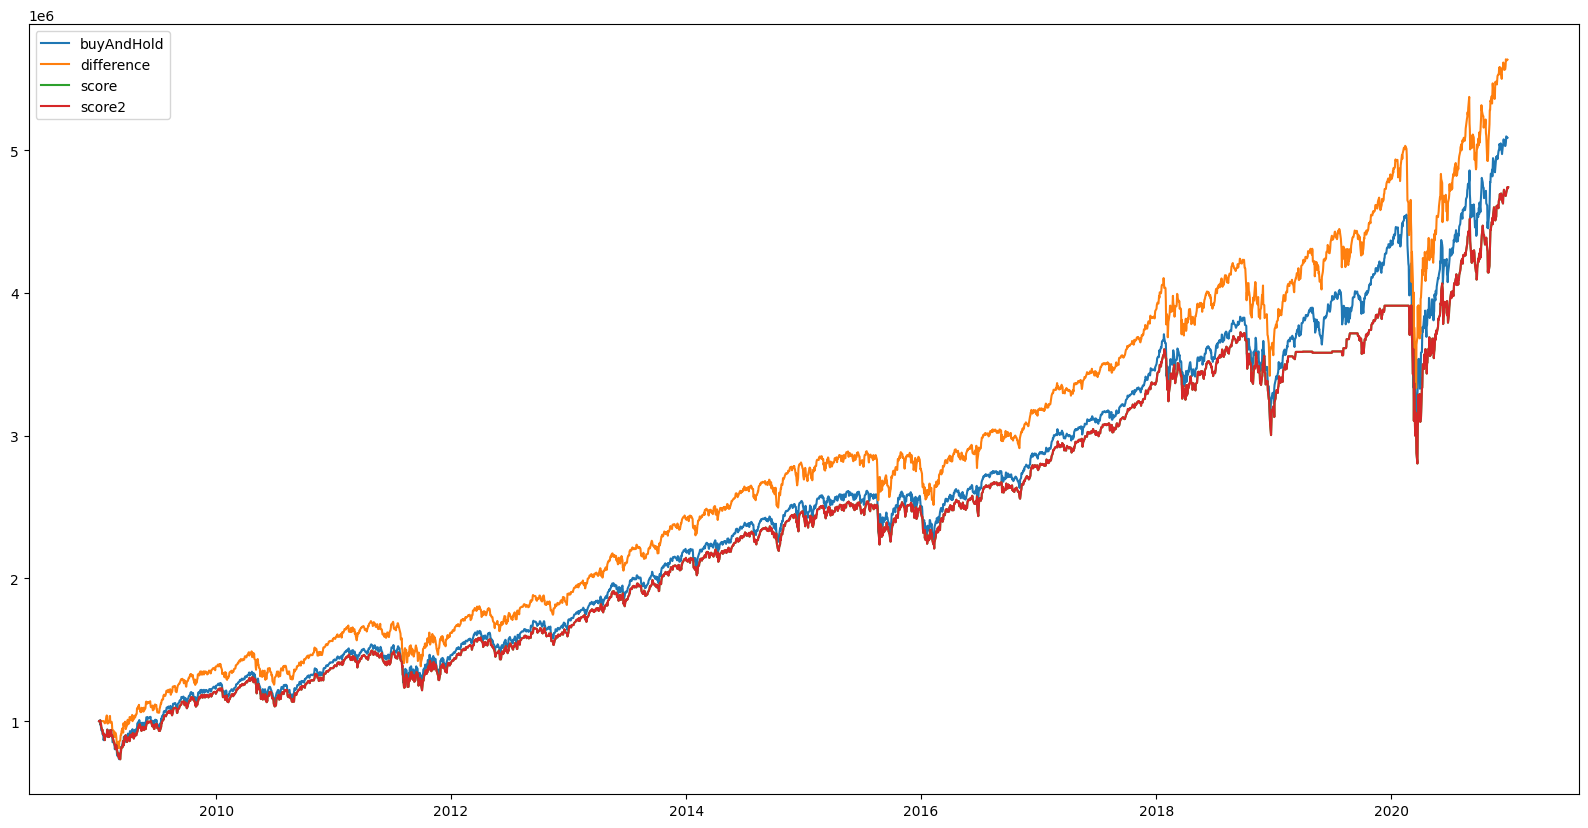

In [56]:
strategy_buyAndHold(df)
strategy_difference(df)
strategy_score(df)
strategy_score2(df)

# 그래프 그리기
plt.figure(figsize=(20, 10))
plt.plot(df.index[:-2], buyAndHold_plt, label="buyAndHold")
plt.plot(df.index[:-2], difference_plt, label="difference")
plt.plot(df.index, score_plt, label="score")
plt.plot(df.index, score2_plt, label="score2")
plt.legend()
plt.show()